In [22]:
import matplotlib.pyplot as plt
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets
import numpy as np
import pandas as pd
import os

from sklearn.neighbors import KNeighborsClassifier  ## KNN
from sklearn.linear_model import LogisticRegressionCV  ## logistic regression
from sklearn.tree import DecisionTreeClassifier  ## decision tree
from sklearn.svm import SVC  ## SVM

# visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Load Data

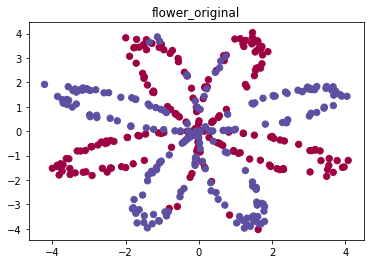

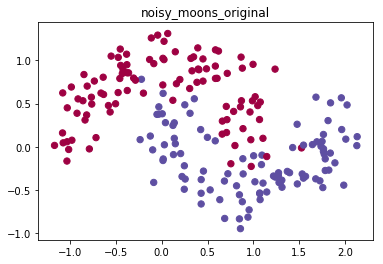

In [10]:
# First Dataset
datas = []
X, Y = load_planar_dataset()
name = 'flower'
X = X.T
Y = Y[0]
datas.append((name, X, Y))

# Second Dataset
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()
datas.append(("noisy_moons", noisy_moons[0], noisy_moons[1]))

# Visualize
for name, X, Y in datas:
    plt.scatter(X[:, 0], X[:, 1], c=Y , s=40, cmap=plt.cm.Spectral);
    plt.title(name+'_original')
    plt.savefig(os.path.join('pic', name+'_original'))
    plt.show()

# K Nearest Neighbor(KNN)

Accuracy 91.5%


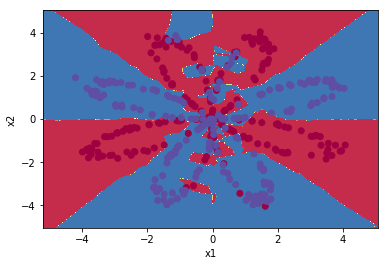

Accuracy 96.5%


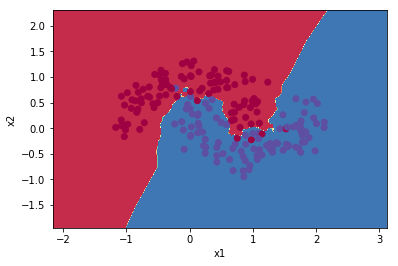

In [23]:
for name, X, Y in datas:
    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(X, Y) 

    y_pred = clf.predict(X)
    print('Accuracy',  str((Y == y_pred).sum()/ X.shape[0]*100)+"%")
    
    plot_decision_boundary(lambda x: clf.predict(x), X.T, Y)
    plt.show()

# Logistic Regression

Accuracy 47.0%


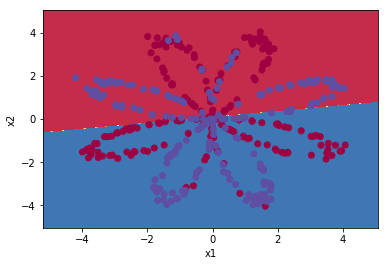

Accuracy 87.0%


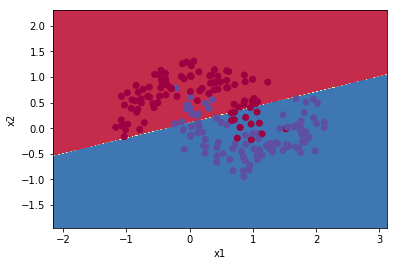

In [24]:
for name, X, Y in datas:
    clf = LogisticRegressionCV()
    clf.fit(X, Y)
    
    y_pred = clf.predict(X)
    print('Accuracy',  str((Y == y_pred).sum()/ X.shape[0]*100)+"%")
    
    plot_decision_boundary(lambda x: clf.predict(x), X.T, Y)
    plt.show()


# Decision Tree

Accuracy 100.0%


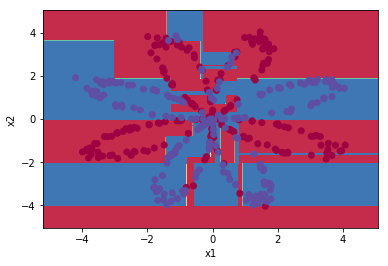

Accuracy 100.0%


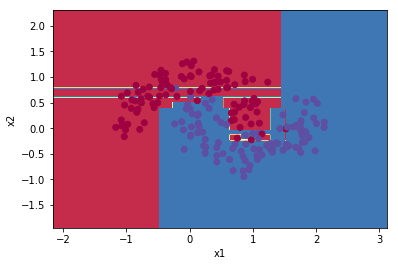

In [25]:
for name, X, Y in datas:
    clf = DecisionTreeClassifier()
    clf.fit(X, Y)
    
    y_pred = clf.predict(X)
    print('Accuracy',  str((Y == y_pred).sum()/ X.shape[0]*100)+"%")
    
    plot_decision_boundary(lambda x: clf.predict(x), X.T, Y)
    plt.show()

# Suport Vector Machine(SVM)

Accuracy 84.0%


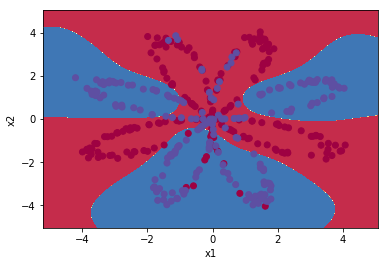

Accuracy 92.5%


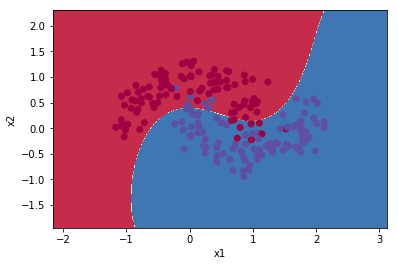

In [26]:
for name, X, Y in datas:
    clf = SVC()
    clf.fit(X, Y)
    
    y_pred = clf.predict(X)
    print('Accuracy',  str((Y == y_pred).sum()/ X.shape[0]*100)+"%")
    
    plot_decision_boundary(lambda x: clf.predict(x), X.T, Y)
    plt.show()